In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Flatten
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Dense
import pandas as pd
import numpy as np
import cv2 as cv
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib.pyplot import imshow
%matplotlib inline
from keras.callbacks import TensorBoard
import random
import os

Using TensorFlow backend.


# Loading Images

In [53]:
seenValidation = pd.read_csv("./seen-dataset/dataset_seen_validation_siamese.csv")
seenTraining = pd.read_csv("./dataset_seen_training_siamese.csv")
seenTraining = seenTraining.drop(seenTraining.columns[[0]],axis=1)
imgSeenTrainLoc = "./seen-dataset/TrainingSet/"
imgSeenTestLoc = "./seen-dataset/ValidationSet/"
trainSeenImgsList = os.listdir(imgSeenTrainLoc)
testSeenImgsList = os.listdir(imgSeenTestLoc)
trainSeenImgsList.sort()
testSeenImgsList.sort()

trainSeenImgs = []
for i in range(len(trainSeenImgsList)):
    trainSeenImgs.append((cv.imread(imgSeenTrainLoc+trainSeenImgsList[i],0).astype('float')/255).reshape((64,64,1)))
trainSeenImgs = np.asarray(trainSeenImgs)
trainSeenImgs.shape

testSeenImgs = []
for i in range(len(testSeenImgsList)):
    testSeenImgs.append((cv.imread(imgSeenTestLoc+testSeenImgsList[i],0).astype('float')/255).reshape((64,64,1)))
testSeenImgs = np.asarray(testSeenImgs)
testSeenImgs.shape

(952, 64, 64, 1)

In [3]:
shuffleValidation = pd.read_csv("./dataset_shuffled_validation_siamese.csv")
shuffleTraining = pd.read_csv("./dataset_shuffled_training_siamese.csv")
shuffleTraining = shuffleTraining.drop(shuffleTraining.columns[[0]],axis=1)
imgShuffleTrainLoc = "./shuffled-dataset/TrainingSet/"
imgShuffleTestLoc = "./shuffled-dataset/ValidationSet/"
trainShuffleImgsList = os.listdir(imgShuffleTrainLoc)
testShuffleImgsList = os.listdir(imgShuffleTestLoc)
#trainShuffleImgsList.sort()
#testShuffleImgsList.sort()


trainShuffleImgs = []
for i in range(len(trainShuffleImgsList)):
    trainShuffleImgs.append((cv.imread(imgShuffleTrainLoc+trainShuffleImgsList[i],0).astype('float')/255).reshape((64,64,1)))
trainShuffleImgs = np.asarray(trainShuffleImgs)
trainShuffleImgs.shape

testShuffleImgs = []
for i in range(len(testShuffleImgsList)):
    testShuffleImgs.append((cv.imread(imgShuffleTestLoc+testShuffleImgsList[i],0).astype('float')/255).reshape((64,64,1)))
testShuffleImgs = np.asarray(testShuffleImgs)
testShuffleImgs.shape

(1971, 64, 64, 1)

In [4]:
unseenValidation = pd.read_csv("./dataset_unseen_validation_siamese.csv")
unseenTraining = pd.read_csv("./dataset_unseen_training_siamese.csv")
unseenTraining = unseenTraining.drop(unseenTraining.columns[[0]],axis=1)
imgUnseenTrainLoc = "./Unseen-dataset/TrainingSet/"
imgUnseenTestLoc = "./Unseen-dataset/ValidationSet/"
trainUnseenImgsList = os.listdir(imgUnseenTrainLoc)
testUnseenImgsList = os.listdir(imgUnseenTestLoc)
#trainUnseenImgsList.sort()
#testUnseenImgsList.sort()


trainUnseenImgs = []
for i in range(len(trainUnseenImgsList)):
    trainUnseenImgs.append((cv.imread(imgUnseenTrainLoc+trainUnseenImgsList[i],0).astype('float')/255).reshape((64,64,1)))
trainUnseenImgs = np.asarray(trainUnseenImgs)
trainUnseenImgs.shape

testUnseenImgs = []
for i in range(len(testUnseenImgsList)):
    testUnseenImgs.append((cv.imread(imgUnseenTestLoc+testUnseenImgsList[i],0).astype('float')/255).reshape((64,64,1)))
testUnseenImgs = np.asarray(testUnseenImgs)
testUnseenImgs.shape

(888, 64, 64, 1)

In [5]:
def getModel():
    imDim = 64
    input_shape  = (imDim,imDim,1)
    inp_img = Input(shape = (imDim,imDim,1), name = 'ImageInput')
    model = inp_img

    #     model = Input(shape=(imDim,imDim,1))
    #     model.add(Input(shape = (imDim,imDim,1), name = 'FeatureNet_ImageInput'))
    model = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='valid')(model)
    #     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model = MaxPooling2D((2,2), padding='valid')(model)
    model = Conv2D(64, (3, 3), activation='relu',padding='valid')(model)
    #     model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
    model = MaxPooling2D((2,2),padding='valid')(model)
    #     model.add(Conv2D(16, (3, 3), activation='relu',padding='same'))
    model = Conv2D(128, (3, 3), activation='relu',padding='valid')(model)
    model = MaxPooling2D((2,2),padding='valid')(model)
    #     model.add(Conv2D(1, (3, 3), activation='relu',padding='same'))
    #     model.add(Conv2D(2, (3, 3), activation='relu',padding='same'))

    model = Conv2D(256, (1, 1), activation='relu',padding='valid')(model)
    model = MaxPooling2D((2,2),padding='valid')(model)

    model = Conv2D(64, (1, 1), activation='relu',padding='valid')(model)
    # model = MaxPooling2D((2,2),padding='valid')(model)
    model = Flatten()(model)

    # img_in = np.array((-1,imDim,imDim,1), dtype='float32')
    # img_in = tf.placeholder(shape=(imDim,imDim,1), dtype='float32')

    feat = Model(inputs=[inp_img], outputs=[model],name = 'Feat_Model')
    feat.summary()


    # In[27]:

    left_img = Input(shape = (imDim,imDim,1), name = 'left_img')
    right_img = Input(shape = (imDim,imDim,1), name = 'right_img')


    # In[28]:

    left_feats = feat(left_img)
    right_feats = feat(right_img)


    # In[35]:

    from keras.layers import concatenate
    import random


    # In[36]:

    merged_feats = concatenate([left_feats, right_feats], name = 'concat_feats')
    merged_feats = Dense(1024, activation = 'linear')(merged_feats)
    merged_feats = BatchNormalization()(merged_feats)
    merged_feats = Activation('relu')(merged_feats)
    merged_feats = Dense(4, activation = 'linear')(merged_feats)
    merged_feats = BatchNormalization()(merged_feats)
    merged_feats = Activation('relu')(merged_feats)
    merged_feats = Dense(1, activation = 'sigmoid')(merged_feats)
    similarity_model = Model(inputs = [left_img, right_img], outputs = [merged_feats], name = 'Similarity_Model')
    
    return similarity_model

## AutoEncoder Model

Instructions for updating:
Colocations handled automatically by placer.


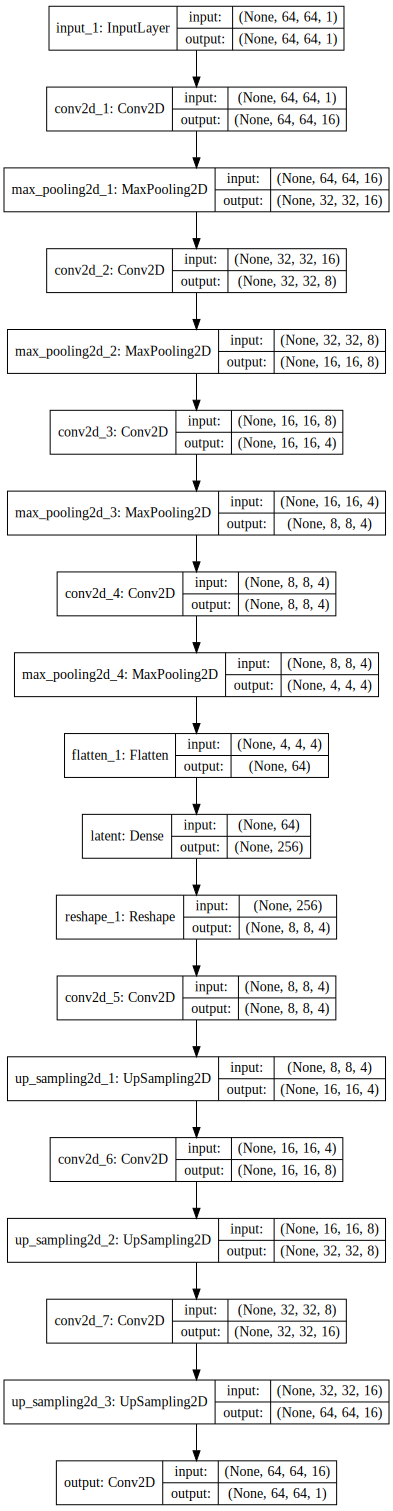

In [6]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
# x = CoordinateChannel2D()(input_img)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = CoordinateChannel2D()(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = CoordinateChannel2D()(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(encoded)
encoded = Dense(8*8*4, activation='relu', name='latent')(encoded)
# model = Model(input_img,encoded)
# print(model.summary())
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
r = Reshape(target_shape=(8,8,4))(encoded)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(r)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoderSeen = Model(input_img, decoded)
autoencoderSeen.compile(optimizer='adadelta', loss='binary_crossentropy')


autoencoderShuffle = Model(input_img, decoded)
autoencoderShuffle.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoderUnseen = Model(input_img, decoded)
autoencoderUnseen.compile(optimizer='adadelta', loss='binary_crossentropy')
#autoencoder.summary()

encoderSeen = Model(input_img, encoded)
encoderShuffle = Model(input_img, encoded)
encoderUnseen = Model(input_img, encoded)
#encoder.summary()
display(SVG(model_to_dot(autoencoderSeen, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))


In [7]:
def dataGen(bSize, imgData):
    count = 0
    sameW = imgData[imgData['label']==1].reset_index()
    #print (sameW)
    diffW = imgData[imgData['label']==0].reset_index()
    #print (diffW)
    while True:
        count = 0
        left, right = [], []
        label = []
        sameWIndexes = np.random.randint(0,len(sameW),bSize//2)
        diffWIndexes = np.random.randint(0,len(diffW),bSize//2)
        for sameWInd in sameWIndexes:
            imgL = (cv.imread(imgLoc+sameW['left'][sameWInd],0)).reshape((64,64,1))
            imgR = (cv.imread(imgLoc+sameW['right'][sameWInd],0)).reshape((64,64,1))
            left.append(imgL)
            right.append(imgR)
            label.append(1)
            count+=1
        for diffWInd in diffWIndexes:

            imgLR = (cv.imread(imgLoc+diffW['left'][diffWInd],0)).reshape((64,64,1))
           
            imgRR = (cv.imread(imgLoc+diffW['right'][diffWInd],0)).reshape((64,64,1))
            left.append(imgL)
            right.append(imgR)
            label.append(0)
            count+=1
        yield [left,right], label
        

In [9]:
optimizer = Adam(lr = 0.00005)
autoencoderSeen.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
random.shuffle(trainSeenImgs)
histSeen = autoencoderSeen.fit(trainSeenImgs, trainSeenImgs, 
                epochs=20,
                batch_size=128,
                shuffle=True)

Epoch 1/20
12846/12846 [==============================] - 110s 9ms/step - loss: 0.6059 - acc: 0.8876
Epoch 2/20
12846/12846 [==============================] - 106s 8ms/step - loss: 0.3414 - acc: 0.8877
Epoch 3/20
12846/12846 [==============================] - 104s 8ms/step - loss: 0.2449 - acc: 0.8877
Epoch 4/20
12846/12846 [==============================] - 106s 8ms/step - loss: 0.2201 - acc: 0.8877
Epoch 5/20
12846/12846 [==============================] - 109s 8ms/step - loss: 0.2089 - acc: 0.8877
Epoch 6/20
12846/12846 [==============================] - 105s 8ms/step - loss: 0.2028 - acc: 0.8877
Epoch 7/20
12846/12846 [==============================] - 108s 8ms/step - loss: 0.1987 - acc: 0.8877
Epoch 8/20
12846/12846 [==============================] - 92s 7ms/step - loss: 0.1954 - acc: 0.8877
Epoch 9/20
12846/12846 [==============================] - 92s 7ms/step - loss: 0.1921 - acc: 0.8877
Epoch 10/20
12846/12846 [==============================] - 92s 7ms/step - loss: 0.1893 - acc:

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb91c08160>,
      dtype=object)

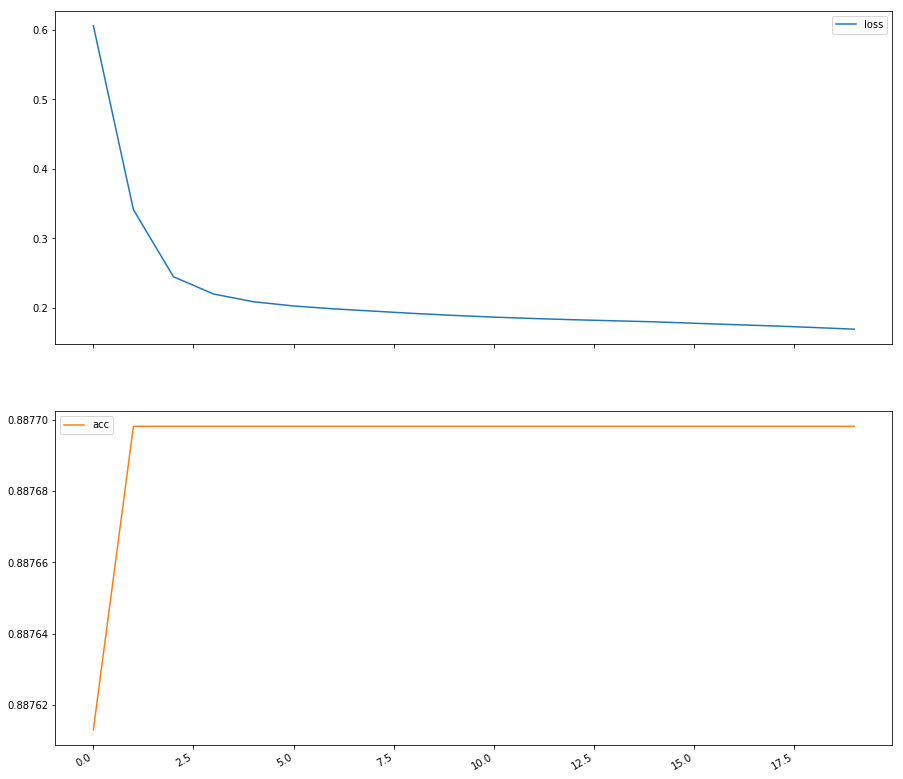

In [44]:
df_hist = pd.DataFrame(histSeen.history)
df_hist.plot(subplots=True, figsize=(15,15))

In [10]:
autoencoderShuffle.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
random.shuffle(trainShuffleImgs)
histShuffle = autoencoderShuffle.fit(trainShuffleImgs, trainShuffleImgs, 
                epochs=20,
                batch_size=128,
                shuffle=True)

Epoch 1/20
11823/11823 [==============================] - 87s 7ms/step - loss: 0.1583 - acc: 0.8920
Epoch 2/20
11823/11823 [==============================] - 85s 7ms/step - loss: 0.1537 - acc: 0.8920
Epoch 3/20
11823/11823 [==============================] - 85s 7ms/step - loss: 0.1515 - acc: 0.8920
Epoch 4/20
11823/11823 [==============================] - 85s 7ms/step - loss: 0.1497 - acc: 0.8919
Epoch 5/20
11823/11823 [==============================] - 85s 7ms/step - loss: 0.1484 - acc: 0.8918
Epoch 6/20
11823/11823 [==============================] - 84s 7ms/step - loss: 0.1474 - acc: 0.8917
Epoch 7/20
11823/11823 [==============================] - 85s 7ms/step - loss: 0.1465 - acc: 0.8916
Epoch 8/20
11823/11823 [==============================] - 84s 7ms/step - loss: 0.1457 - acc: 0.8915
Epoch 9/20
11823/11823 [==============================] - 85s 7ms/step - loss: 0.1450 - acc: 0.8914
Epoch 10/20
11823/11823 [==============================] - 85s 7ms/step - loss: 0.1444 - acc: 0.8913

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb8c148080>,
      dtype=object)

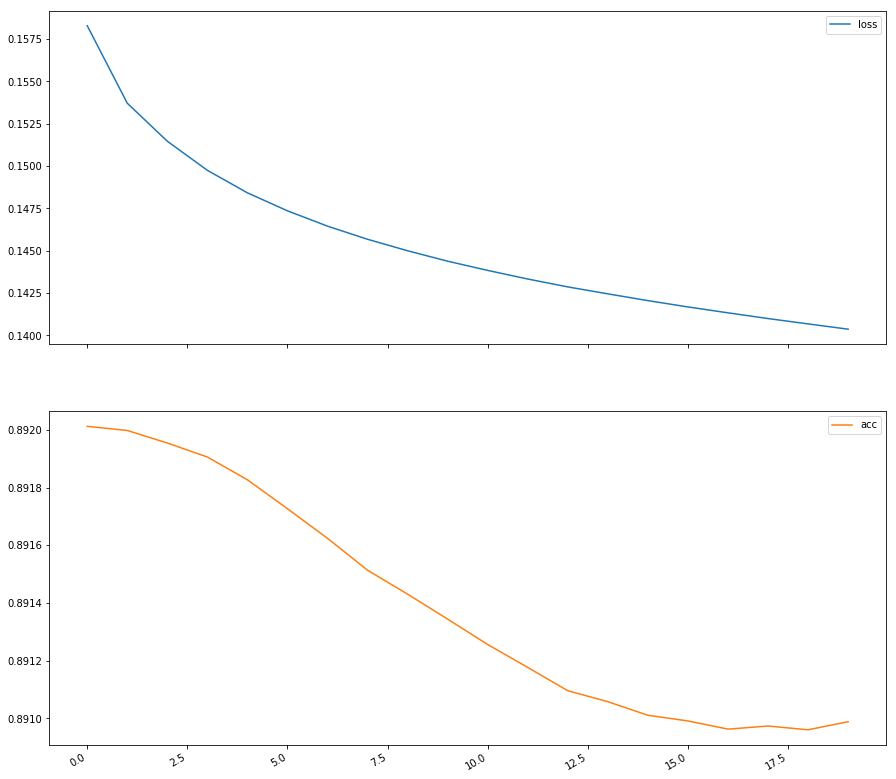

In [47]:
df_hist = pd.DataFrame(histShuffle.history)
df_hist.plot(subplots=True, figsize=(15,15))

In [11]:
autoencoderUnseen.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
random.shuffle(trainUnseenImgs)
histUnseen = autoencoderUnseen.fit(trainUnseenImgs, trainUnseenImgs, 
                epochs=20,
                batch_size=128,
                shuffle=True)

Epoch 1/20
12906/12906 [==============================] - 94s 7ms/step - loss: 0.1452 - acc: 0.8870
Epoch 2/20
12906/12906 [==============================] - 91s 7ms/step - loss: 0.1443 - acc: 0.8870
Epoch 3/20
12906/12906 [==============================] - 91s 7ms/step - loss: 0.1438 - acc: 0.8870
Epoch 4/20
12906/12906 [==============================] - 91s 7ms/step - loss: 0.1433 - acc: 0.8870
Epoch 5/20
12906/12906 [==============================] - 91s 7ms/step - loss: 0.1429 - acc: 0.8870
Epoch 6/20
12906/12906 [==============================] - 91s 7ms/step - loss: 0.1426 - acc: 0.8870
Epoch 7/20
12906/12906 [==============================] - 91s 7ms/step - loss: 0.1423 - acc: 0.8870
Epoch 8/20
12906/12906 [==============================] - 91s 7ms/step - loss: 0.1420 - acc: 0.8870
Epoch 9/20
12906/12906 [==============================] - 92s 7ms/step - loss: 0.1418 - acc: 0.8870
Epoch 10/20
12906/12906 [==============================] - 92s 7ms/step - loss: 0.1415 - acc: 0.8870

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb932bba20>,
      dtype=object)

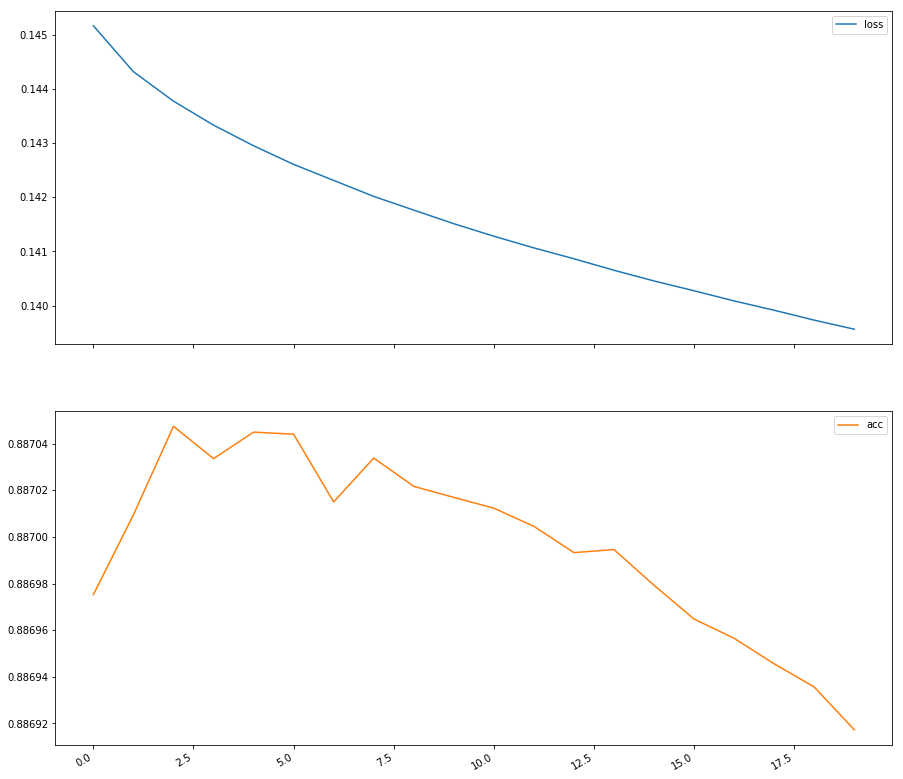

In [48]:
df_hist = pd.DataFrame(histUnseen.history)
df_hist.plot(subplots=True, figsize=(15,15))

In [14]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [16]:
def getSimMat(encoder, testImgs):
    pred = encoder.predict(testImgs)
    simMat = []
    for img1 in pred:
        simMatTemp = []
        for img2 in pred:
            simMatTemp.append(cos_sim(img1,img2))
        simMat.append(simMatTemp)

    simMat = np.asarray(simMat)
    return pred, simMat

In [17]:
def getTrueFalse(simMat, testImgsList, thres):
    trueP, trueN, falseP, falseN = 0, 0, 0, 0
    threshold = thres
    for i in range(simMat.shape[0]):
        for j in range(simMat.shape[0]):
            if (testImgsList[i][:4] == testImgsList[j][:4]):
                if (simMat[i][j] > threshold):
                    trueP+=1
                else:
                    falseN+=1
            else:
                if (simMat[i][j] > threshold):
                    falseP+=1
                else:
                    trueN+=1
    return trueP, trueN, falseP, falseN

In [39]:
def calAccuracy(testImgsList, simMat, threshold):
    count = 0
    for i in range(len(testImgsList)):
        for j in range(len(testImgsList)):
            if ((testImgsList[i][:4] == testImgsList[j][:4]) and (simMat[i][j] >threshold)):
                count +=1
            elif ((testImgsList[i][:4] != testImgsList[j][:4]) and (simMat[i][j] < threshold)) :
                count +=1
            else : 
                continue
    acc = count/(len(testImgsList)**2)*100
    return acc

## Siamese Model

In [50]:
def train(model, imgData, numIter, bSize):
    c=0
    for batchData in dataGen(bSize, imgData):
        if (c==numIter):
            break
        loss = model.train_on_batch(batchData[0], batchData[1])
        print(loss)
        c+=1
    

In [58]:
model = getModel()
#model = modelAutoEncoder()
optimizer = Adam(lr = 0.00005)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])
#model.fit()
#model.fit_generator(dataGen(model, ))
#train(model, seenTraining, 1000, 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 128)         0         
__________

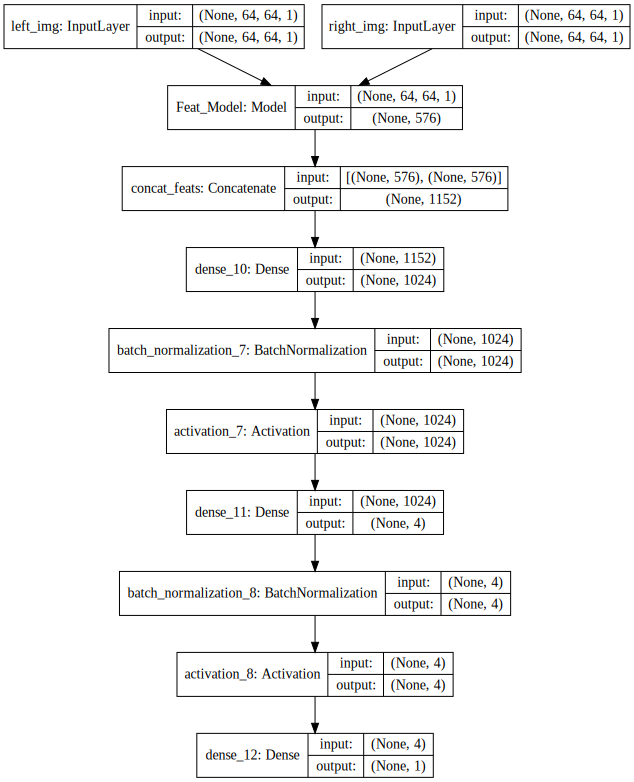

In [59]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))


## Seen Dataset

In [40]:
threshold = 0.9
predSeen, simMatSeen = getSimMat(encoderSeen,testSeenImgs)
valsSeen = getTrueFalse(simMatSeen, testSeenImgsList, threshold)
accSeen = calAccuracy(testSeenImgsList, simMatSeen, threshold)

## Shuffled Dataset

In [41]:
predShuffle, simMatShuffle = getSimMat(encoderShuffle,testShuffleImgs)
valsShuffle = getTrueFalse(simMatShuffle, testShuffleImgsList, threshold)
accShuffle = calAccuracy(testShuffleImgsList, simMatShuffle, threshold)

## Unseen Dataset

In [42]:
predUnseen, simMatUnseen = getSimMat(encoderUnseen,testUnseenImgs)
valsUnseen = getTrueFalse(simMatUnseen, testUnseenImgsList, threshold)
accUnseen = calAccuracy(testUnseenImgsList, simMatUnseen, threshold)

In [43]:
print ("Seen Accuracy :",accSeen)
print ("Shuffle Accuracy :", accShuffle)
print ("Unseen Accuracy :", accUnseen)

Seen Accuracy : 3.479847821481534
Shuffle Accuracy : 3.3106374237710114
Unseen Accuracy : 3.1478268809349887


In [60]:
print ("TrueP, TrueF, FalseP, FalseN")
print ("Seen :",valsSeen)
print ("Shuffle :", valsShuffle)
print ("Unseen :", valsUnseen)

TrueP, TrueF, FalseP, FalseN
Seen : (1852, 29686, 874760, 6)
Shuffle : (7223, 121390, 3756192, 36)
Unseen : (8426, 16396, 763680, 42)
